In [0]:
%pip install --upgrade --force-reinstall -r https://aka.ms/automl_linux_requirements.txt

Python interpreter will be restarted.
Collecting adal<=1.2.6
 Using cached adal-1.2.6-py2.py3-none-any.whl (55 kB)
Collecting applicationinsights<=0.11.9
 Using cached applicationinsights-0.11.9-py2.py3-none-any.whl (58 kB)
Collecting azure-common<=1.1.27
 Using cached azure_common-1.1.27-py2.py3-none-any.whl (12 kB)
Collecting azure-core<=1.13.0
 Using cached azure_core-1.13.0-py2.py3-none-any.whl (133 kB)
Collecting azure-graphrbac<=0.61.1
 Using cached azure_graphrbac-0.61.1-py2.py3-none-any.whl (141 kB)
Collecting azure-identity<=1.4.1
 Using cached azure_identity-1.4.1-py2.py3-none-any.whl (86 kB)
Collecting azure-mgmt-authorization<=0.61.0
 Using cached azure_mgmt_authorization-0.61.0-py2.py3-none-any.whl (94 kB)
Collecting azure-mgmt-containerregistry<=2.8.0
 Using cached azure_mgmt_containerregistry-2.8.0-py2.py3-none-any.whl (718 kB)
Collecting azure-mgmt-keyvault<=2.2.0
 Using cached azure_mgmt_keyvault-2.2.0-py2.py3-none-any.whl (89 kB)
Collecting azure-mgmt-resource<=12.1.0
 Using cached azure_mgmt_resource-12.1.0-py2.py3-none-any.whl (1.1 MB)
Collecting azure-mgmt-storage<=11.2.0
 Using cached azure_mgmt_storage-11.2.0-py2.py3-none-any.whl (547 kB)
Collecting azure-storage-queue<=12.1.5
 Using cached azure_storage_queue-12.1.5-py2.py3-none-any.whl (132 kB)
Collecting azureml-automl-core~=1.26.0
 Using cached azureml_automl_core-1.26.0-py3-none-any.whl (200 kB)
Collecting azureml-automl-runtime~=1.26.0
 Using cached azureml_automl_runtime-1.26.0-py3-none-any.whl (2.0 MB)
Collecting azureml-core~=1.26.0
 Using cached azureml_core-1.26.0-py3-none-any.whl (2.2 MB)
Collecting azureml-dataprep<=2.13.2
 Using cached azureml_dataprep-2.13.2-py3-none-any.whl (39.4 MB)
Collecting azureml-dataprep-native<=32.0.0
 Using cached azureml_dataprep_native-32.0.0-cp37-cp37m-manylinux1_x86_64.whl (1.3 MB)
Collecting azureml-dataprep-rslex<=1.11.2
 Using cached azureml_dataprep_rslex-1.11.2-cp37-cp37m-manylinux1_x86_64.whl (9.5 MB)
Collecting azureml-dataset-runtime~=1.26.0
 Using cached azureml_dataset_runtime-1.26.0-py3-none-any.whl (3.4 kB)
Collecting azureml-defaults~=1.26.0
 Using cached azureml_defaults-1.26.0-py3-none-any.whl (3.1 kB)
Collecting azureml-interpret~=1.26.0
 Using cached azureml_interpret-1.26.0-py3-none-any.whl (52 kB)
Collecting azureml-model-management-sdk<=1.0.1b6.post1
 Using cached azureml_model_management_sdk-1.0.1b6.post1-py2.py3-none-any.whl (130 kB)
Collecting azureml-pipeline-core~=1.26.0
 Using cached azureml_pipeline_core-1.26.0-py3-none-any.whl (309 kB)
Collecting azureml-pipeline-steps~=1.26.0
 Using cached azureml_pipeline_steps-1.26.0-py3-none-any.whl (68 kB)
Collecting azureml-telemetry~=1.26.0
 Using cached azureml_telemetry-1.26.0-py3-none-any.whl (30 kB)
Collecting azureml-train-automl~=1.26.0
 Using cached azureml_train_automl-1.26.0-py3-none-any.whl (3.4 kB)
Collecting azureml-train-automl-client~=1.26.0
 Using cached azureml_train_automl_client-1.26.0-py3-none-any.whl (119 kB)
Collecting azureml-train-automl-runtime~=1.26.0
 Using cached azureml_train_automl_runtime-1.26.0-py3-none-any.whl (144 kB)
Collecting azureml-train-core~=1.26.0
 Using cached azureml_train_core-1.26.0-py3-none-any.whl (8.6 MB)
Collecting azureml-train-restclients-hyperdrive~=1.26.0
 Using cached azureml_train_restclients_hyperdrive-1.26.0-py3-none-any.whl (19 kB)
Collecting backports.tempfile<=1.0
 Using cached backports.tempfile-1.0-py2.py3-none-any.whl (4.4 kB)
Collecting backports.weakref<=1.0.post1
 Using cached backports.weakref-1.0.post1-py2.py3-none-any.whl (5.2 kB)
Collecting boto<=2.49.0
 Using cached boto-2.49.0-py2.py3-none-any.whl (1.4 MB)
Collecting boto3<=1.15.18
 Using cached boto3-1.15.18-py2.py3-none-any.whl (129 kB)
Collecting botocore<=1.18.18
 Using cached botocore-1.18.18-py2.py3-none-any.whl (6.7 MB)
Collecting certifi<=2020.12.5
 Using cached certifi-2020.12.5-py2.py3-none-any.whl (147 kB)
Collecting cffi<=1.14.5
 Using cached cffi-1.14.5-cp37-cp37m-manylinux1_x86_64.whl (402 kB)
Collecting ch

In [0]:
#pip install --upgrade azureml-automl-core

In [0]:
import azureml.core

print("SDK Version:", azureml.core.VERSION)


SDK Version: 1.26.0

In [0]:
# define widgets - NEED TO DEFINE IT ONCE
# dynamic variables (pass it from ADF)
# first time runtime parameter
# dbutils.widgets.dropdown("environment", "dev", ["dev","uat","prod"])
# dbutils.widgets.dropdown("new_training", "False", ["True","False"])
# dbutils.widgets.dropdown("system_name", "bimodelapi", ["bimodelapi"])
# dbutils.widgets.text("system_name", "","")
# dbutils.widgets.remove("pbiapi")
environment = dbutils.widgets.get("environment")
new_training = dbutils.widgets.get("new_training")
system_name = dbutils.widgets.get("system_name")
if environment in {"prod"}:
    aml_compute_cluster_name = "cc-bi-ml-prod01"
else:
    aml_compute_cluster_name = "cc-bi-ml-devqa01"

print(environment, system_name, new_training, aml_compute_cluster_name)

dev bimodelapi True cc-bi-ml-devqa01

dev bimodelapi True cc-bi-ml-devqa01

dev bimodelapi True cc-bi-ml-devqa01

EnvironmentName,ParameterName,ParameterValue,SystemName
dev,ws_resource_group,rg-bi-automl-devqa01,bimodelapi
dev,workspace_name,mlw-bi-automl-devqa01,bimodelapi
dev,workspace_region,westus,bimodelapi


0 : ^GSPC,1 : ^FTSE,2 : ^N100,3 : ^N225,4 : 000001.SS,

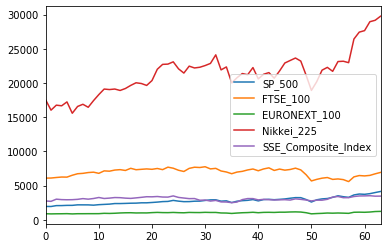

pipehist : (82186, 9)
talenthist : (4591, 6)
revhist : (424, 3)
opphist : (593, 7)
projhist : (701, 7)
pipetrend : (1245, 4)
projectactualshist : (1697, 4)

Out[14]: array(['2020-02-16T00:00:00.000000000', '2020-02-23T00:00:00.000000000',
 '2020-02-29T00:00:00.000000000', '2020-03-01T00:00:00.000000000',
 '2020-03-08T00:00:00.000000000', '2020-03-15T00:00:00.000000000',
 '2020-03-22T00:00:00.000000000', '2020-06-07T00:00:00.000000000',
 '2020-06-14T00:00:00.000000000', '2020-06-21T00:00:00.000000000',
 '2020-06-28T00:00:00.000000000', '2020-06-30T00:00:00.000000000',
 '2020-07-05T00:00:00.000000000', '2020-07-12T00:00:00.000000000',
 '2020-07-19T00:00:00.000000000', '2020-07-26T00:00:00.000000000',
 '2020-07-31T00:00:00.000000000', '2020-08-02T00:00:00.000000000',
 '2020-08-09T00:00:00.000000000', '2020-08-16T00:00:00.000000000',
 '2020-08-23T00:00:00.000000000', '2020-08-30T00:00:00.000000000',
 '2020-08-31T00:00:00.000000000', '2020-09-06T00:00:00.000000000',
 '2020-09-13T00:00:00.000000000', '2020-09-20T00:00:00.000000000',
 '2020-09-27T00:00:00.000000000', '2020-09-30T00:00:00.000000000',
 '2020-10-04T00:00:00.000000000', '2020-10-11T00:00:00.000000000',
 '2020-10-18T00:00:00.000000000', '2020-10-25T00:00:00.000000000',
 '2020-10-31T00:00:00.000000000', '2020-11-01T00:00:00.000000000',
 '2020-11-08T00:00:00.000000000', '2020-11-15T00:00:00.000000000',
 '2020-11-22T00:00:00.000000000', '2020-11-29T00:00:00.000000000',
 '2020-11-30T00:00:00.000000000', '2020-12-06T00:00:00.000000000',
 '2020-12-13T00:00:00.000000000', '2020-12-20T00:00:00.000000000',
 '2020-12-27T00:00:00.000000000', '2020-12-31T00:00:00.000000000',
 '2021-01-03T00:00:00.000000000', '2021-01-10T00:00:00.000000000',
 '2021-01-17T00:00:00.000000000', '2021-01-24T00:00:00.000000000',
 '2021-01-31T00:00:00.000000000', '2021-02-07T00:00:00.000000000',
 '2021-02-14T00:00:00.000000000', '2021-02-21T00:00:00.000000000',
 '2021-02-28T00:00:00.000000000', '2021-03-07T00:00:00.000000000',
 '2021-03-14T00:00:00.000000000', '2021-03-21T00:00:00.000000000',
 '2021-03-28T00:00:00.000000000', '2021-03-31T00:00:00.000000000',
 '2021-04-03T00:00:00.000000000', '2021-04-04T00:00:00.000000000',
 '2021-04-05T00:00:00.000000000', '2021-04-06T00:00:00.000000000',
 '2021-04-07T00:00:00.000000000', '2021-04-08T00:00:00.000000000',
 '2021-04-09T00:00:00.000000000', '2019-11-24T00:00:00.000000000',
 '2019-11-30T00:00:00.000000000', '2019-12-01T00:00:00.000000000',
 '2019-12-08T00:00:00.000000000', '2019-12-15T00:00:00.000000000',
 '2019-12-22T00:00:00.000000000', '2019-12-29T00:00:00.000000000',
 '2019-12-31T00:00:00.000000000', '2020-01-05T00:00:00.000000000',
 '2020-01-12T00:00:00.000000000', '2020-01-19T00:00:00.000000000',
 '2020-01-26T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
 '2020-02-02T00:00:00.000000000', '2020-02-09T00:00:00.000000000',
 '2020-03-29T00:00:00.000000000', '2020-03-31T00:00:00.000000000',
 '2020-04-05T00:00:00.000000000', '2020-04-12T00:00:00.000000000',
 '2020-04-19T00:00:00.000000000', '2020-04-26T00:00:00.000000000',
 '2020-04-30T00:00:00.000000000', '2020-05-03T00:00:00.000000000',
 '2020-05-10T00:00:00.000000000', '2020-05-17T00:00:00.000000000',
 '2020-05-24T00:00:00.000000000', '2020-05-31T00:00:00.000000000',
 '2019-07-28T00:00:00.000000000', '2019-07-31T00:00:00.000000000',
 '2019-08-04T00:00:00.000000000', '2019-08-11T00:00:00.000000000',
 '2019-08-18T00:00:00.000000000', '2019-08-25T00:00:00.000000000',
 '2019-08-31T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
 '2019-09-08T00:00:00.000000000', '2019-09-15T00:00:00.000000000',
 '2019-09-22T00:00:00.000000000', '2019-09-29T00:00:00.000000000',
 '2019-09-30T00:00:00.000000000', '2019-10-06T00:00:00.000000000',
 '2019-10-13T00:00:00.000000000', '2019-10-20T00:00:00.000000000',
 '2019-10-27T00:00:00.000000000', '2019-10-31T00:00:00.000000000',
 '2019-11-03T00:00:00.000000000', '2019-11-10T00:00:00.000000000',
 '2019-11-17T00:00:00.000000000', '2018-07-20T00:00:00.000000000',
 '2018-07-22T00:00:00.000000000', '2018-07-29T00:00:00.000000000',
 '2018-07-31T00:00:00.000000000', '2018-08-05T00:00:00.000000000',
 '2018-08-12T00:00:00.000000000'

Out[15]: array(['2021-01-31T00:00:00.000000000', '2021-02-28T00:00:00.000000000',
 '2021-03-31T00:00:00.000000000', '2021-04-30T00:00:00.000000000',
 '2021-05-31T00:00:00.000000000', '2021-06-30T00:00:00.000000000',
 '2021-07-31T00:00:00.000000000', '2021-10-31T00:00:00.000000000',
 '2021-11-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000',
 '2022-01-31T00:00:00.000000000', '2021-08-31T00:00:00.000000000',
 '2021-09-30T00:00:00.000000000', '2022-02-28T00:00:00.000000000',
 '2022-03-31T00:00:00.000000000', '2017-01-31T00:00:00.000000000',
 '2017-02-28T00:00:00.000000000', '2017-03-31T00:00:00.000000000',
 '2017-04-30T00:00:00.000000000', '2017-05-31T00:00:00.000000000',
 '2017-06-30T00:00:00.000000000', '2017-07-31T00:00:00.000000000',
 '2017-08-31T00:00:00.000000000', '2017-09-30T00:00:00.000000000',
 '2017-10-31T00:00:00.000000000', '2017-11-30T00:00:00.000000000',
 '2017-12-31T00:00:00.000000000', '2018-01-31T00:00:00.000000000',
 '2018-02-28T00:00:00.000000000', '2018-03-31T00:00:00.000000000',
 '2018-04-30T00:00:00.000000000', '2018-05-31T00:00:00.000000000',
 '2018-06-30T00:00:00.000000000', '2018-07-31T00:00:00.000000000',
 '2018-08-31T00:00:00.000000000', '2018-09-30T00:00:00.000000000',
 '2018-10-31T00:00:00.000000000', '2018-11-30T00:00:00.000000000',
 '2018-12-31T00:00:00.000000000', '2019-01-31T00:00:00.000000000',
 '2019-02-28T00:00:00.000000000', '2019-03-31T00:00:00.000000000',
 '2019-04-30T00:00:00.000000000', '2019-05-31T00:00:00.000000000',
 '2019-06-30T00:00:00.000000000', '2019-07-31T00:00:00.000000000',
 '2019-08-31T00:00:00.000000000', '2019-09-30T00:00:00.000000000',
 '2019-10-31T00:00:00.000000000', '2019-11-30T00:00:00.000000000',
 '2019-12-31T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
 '2020-02-29T00:00:00.000000000', '2020-03-31T00:00:00.000000000',
 '2020-04-30T00:00:00.000000000', '2020-05-31T00:00:00.000000000',
 '2020-06-30T00:00:00.000000000', '2020-07-31T00:00:00.000000000',
 '2020-08-31T00:00:00.000000000', '2020-09-30T00:00:00.000000000',
 '2020-10-31T00:00:00.000000000', '2020-11-30T00:00:00.000000000',
 '2020-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

Preparing data
x : (82186, 9)
x : (4591, 6)
x : (424, 3)
x : (593, 7)
x : (701, 7)
x : (1245, 4)
x : (1697, 4)

Preparing eom_region_snp_final
eom_region_snp_final:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4352 entries, 0 to 4351
Data columns (total 8 columns):
Snapshot_Date 4352 non-null datetime64[ns]
End_of_Month 4352 non-null datetime64[ns]
Sub_Region_Code 4352 non-null object
Relative_Month_Offset 4352 non-null int64
Relative_Snapshot_Month_Offset 4352 non-null int64
Relative_Offset 4352 non-null int64
Snapshot_Day_of_Month 4352 non-null int64
Snp_Seq_No 4352 non-null int64
dtypes: datetime64[ns](2), int64(5), object(1)
memory usage: 272.1+ KB
Out[17]:

,Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_Offset,Snapshot_Day_of_Month,Snp_Seq_No
4347,2021-04-07,2021-07-31,Europe,3,0,3,7,6
4348,2021-04-07,2021-07-31,Global,3,0,3,7,6
4349,2021-04-07,2021-07-31,Japan,3,0,3,7,6
4350,2021-04-07,2021-07-31,North America,3,0,3,7,6
4351,2021-04-07,2021-07-31,Play Lab,3,0,3,7,6


Out[18]:

Snapshot_Date 
 
 
 
 Snp_Seq_No 
 6 
 
 
 
 Sub_Region_Code 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 
 
 End_of_Month 
 Relative_Offset 
 
 
 
 
 
 
 
 
 
 
 
 
 2017-07-31 
 -12 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 2017-08-31 
 -12 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 -11 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 2017-09-30 
 -12 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 -11 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 2021-05-31 
 2 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 3 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 2021-06-30 
 2 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 3 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 2021-07-31 
 3 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 
 544 rows × 8 columns

Preparing talent wide
['Revenue', 'Pipeline', 'Pipeline_at_100_Percent', 'Yield', 'Pipeline_Trend', 'Conversions', 'Project_Period_Count', 'Project_Count', 'Project_Period_Price', 'Project_Price', 'Opportunity_Period_Count', 'Opportunity_Count', 'Current_Opp._Period_Value', 'Opportunity Value', 'Win_Rate', 'Headcount', 'Utilization_Billable', 'Headcount_Non-Billable_Team', 'Headcount_Non-Billable_Director', 'Headcount_Non-Billable_Unknown', 'Headcount_Billable_Individual', 'Headcount_Billable_Unknown', 'Headcount_Unknown_Unknown', 'Headcount_Billable_Enterprise', 'Headcount_Billable_Team', 'Headcount_Non-Billable_Enterprise', 'Headcount_Billable_Temp', 'Headcount_Unknown_Team', 'Headcount_Unknown_Enterprise', 'Headcount_Billable_Director', 'Headcount_Unknown_Individual', 'Headcount_Non-Billable_Individual', 'Headcount_Unknown_Director', 'Headcount_Contingent_Non-Billable', 'Headcount_Contingent_Unknown', 'Headcount_Contingent_Billable']
Out[19]: '\n# pipetrend_wide.query(\'Fin_Entity_ID==@entity_debug\')\n#print("talenthist_wide:", talenthist_wide.shape)\n#talenthist_wide.tail() # .query(\'Relative_Snapshot_Month_Offset == 0\')\n'

Preparing ProjectActuals wide
['Revenue', 'Pipeline', 'Pipeline_at_100_Percent', 'Yield', 'Pipeline_Trend', 'Conversions', 'Project_Period_Count', 'Project_Count', 'Project_Period_Price', 'Project_Price', 'Opportunity_Period_Count', 'Opportunity_Count', 'Current_Opp._Period_Value', 'Opportunity Value', 'Win_Rate', 'Headcount', 'Utilization_Billable', 'Headcount_Non-Billable_Team', 'Headcount_Non-Billable_Director', 'Headcount_Non-Billable_Unknown', 'Headcount_Billable_Individual', 'Headcount_Billable_Unknown', 'Headcount_Unknown_Unknown', 'Headcount_Billable_Enterprise', 'Headcount_Billable_Team', 'Headcount_Non-Billable_Enterprise', 'Headcount_Billable_Temp', 'Headcount_Unknown_Team', 'Headcount_Unknown_Enterprise', 'Headcount_Billable_Director', 'Headcount_Unknown_Individual', 'Headcount_Non-Billable_Individual', 'Headcount_Unknown_Director', 'Headcount_Contingent_Non-Billable', 'Headcount_Contingent_Unknown', 'Headcount_Contingent_Billable', 'Utilization_Billable_Enterprise', 'Utilization_Billable_Unknown', 'Utilization_Billable_Team', 'Utilization_Billable_Individual', 'Utilization_Billable_Director', 'Utilization_Billable_Temp']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 8 columns):
End_of_Month 365 non-null datetime64[ns]
Sub_Region_Code 365 non-null object
Utilization_Billable_Director 365 non-null float64
Utilization_Billable_Enterprise 365 non-null float64
Utilization_Billable_Individual 365 non-null float64
Utilization_Billable_Team 365 non-null float64
Utilization_Billable_Temp 365 non-null float64
Utilization_Billable_Unknown 365 non-null float64
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 22.9+ KB
Out[20]: '\n# projectactualshist_wide.query(\'Fin_Entity_ID==@entity_debug\')\nprint("projectactualshist_wide:", projectactualshist_wide.shape)\n'

Out[21]: '\nprint("Preparing Pipeline_Trend Wide")\n\nnan_value = 0\npipetrend_wide = pipetrend1.pivot_table(\n index=["Snapshot_Date", "End_of_Month", "Sub_Region_Code"],\n columns="Pipeline_Type",\n values=["Pipeline_Trend"], # , \'Pipeline_3M_Rolling_Avg\'\n aggfunc={"Pipeline_Trend": np.sum},\n margins=False,\n).fillna(nan_value)\n\n\npipetrend_wide.columns = [\n "_".join(tuple(map(str, t))) for t in pipetrend_wide.columns.values\n]\n\npipe_cols = [\n "Active_Unrecognized_Trend",\n "Opportunity_Trend",\n "Opportunity_ML_Trend", # , "Recognized",\n]\n\npipetrend_wide.columns = pipe_cols\n\npipetrend_wide = pipetrend_wide.reset_index(\n level=pipetrend_wide.index.names\n).reset_index(drop=True)\n\nnumeric_cols_pipetrend = numeric_cols\nnumeric_cols_pipetrend = numeric_cols_pipetrend + pipe_cols\nif "Pipeline_Trend" in numeric_cols_pipetrend:\n numeric_cols_pipetrend.remove("Pipeline_Trend")\nprint(numeric_cols_pipetrend)\n\nnumeric_cols = numeric_cols_pipetrend\npipetrend_wide = convert_date_cols(pipetrend_wide)\npipetrend_wide = coerce_to_numeric(pipetrend_wide)\npipetrend_wide = coerce_to_int(pipetrend_wide)\n\npipetrend_wide = pipetrend_wide.sort_values(by=["Snapshot_Date", "End_of_Month", "Sub_Region_Code"]).reset_index(drop=True)\n\n# print(\' pipetrend_wide: \')\n\ndisplay(pipetrend_wide.info())\n\n# pipetrend_wide.query(\'Fin_Entity_ID==@entity_debug\')\nprint("pipetrend_wide:", pipetrend_wide.shape)\n#pipetrend_wide.tail() # .query(\'Relative_Snapshot_Month_Offset == 0\')\n\n'

Preparing merge_df
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4352 entries, 0 to 4351
Data columns (total 44 columns):
Snapshot_Date 4352 non-null datetime64[ns]
End_of_Month 4352 non-null datetime64[ns]
Sub_Region_Code 4352 non-null object
Relative_Month_Offset 4352 non-null int64
Relative_Snapshot_Month_Offset 4352 non-null int64
Relative_Offset 4352 non-null int64
Snapshot_Day_of_Month 4352 non-null int64
Snp_Seq_No 4352 non-null int64
Revenue 4352 non-null float64
Project_Period_Count 4352 non-null float64
Project_Count 4352 non-null float64
Project_Period_Price 4352 non-null float64
Project_Price 4352 non-null float64
Conversions 4352 non-null float64
Opportunity_Period_Count 4352 non-null float64
Opportunity_Count 4352 non-null float64
Current_Opp._Period_Value 4352 non-null float64
Opportunity_Value 4352 non-null float64
Win_Rate 4352 non-null float64
Utilization_Billable_Director 4352 non-null float64
Utilization_Billable_Enterprise 4352 non-null float64
Utilization_Billable_Individual 4352 non-null float64
Utilization_Billable_Team 4352 non-null float64
Utilization_Billable_Temp 4352 non-null float64
Utilization_Billable_Unknown 4352 non-null float64
Headcount_Billable_Director 4352 non-null float64
Headcount_Billable_Enterprise 4352 non-null float64
Headcount_Billable_Individual 4352 non-null float64
Headcount_Billable_Team 4352 non-null float64
Headcount_Billable_Temp 4352 non-null float64
Headcount_Billable_Unknown 4352 non-null float64
Headcount_Non-Billable_Director 4352 non-null float64
Headcount_Non-Billable_Enterprise 4352 non-null float64
Headcount_Non-Billable_Individual 4352 non-null float64
Headcount_Non-Billable_Team 4352 non-null float64
Headcount_Non-Billable_Unknown 4352 non-null float64
Headcount_Unknown_Director 4352 non-null float64
Headcount_Unknown_Enterprise 4352 non-null float64
Headcount_Unknown_Individual 4352 non-null float64
Headcount_Unknown_Team 4352 non-null float64
Headcount_Unknown_Unknown 4352 non-null float64
Headcount_Contingent_Billable 4352 non-null float64
Headcount_Contingent_Non-Billable 4352 non-null float64
Headcount_Contingent_Unknown 4352 non-null float64
dtypes: datetime64[ns](2), float64(36), int64(5), object(1)
memory usage: 1.5+ MB

Preparing merge_df1
['Revenue', 'Pipeline', 'Pipeline_at_100_Percent', 'Yield', 'Pipeline_Trend', 'Conversions', 'Project_Period_Count', 'Project_Count', 'Project_Period_Price', 'Project_Price', 'Opportunity_Period_Count', 'Opportunity_Count', 'Current_Opp._Period_Value', 'Opportunity Value', 'Win_Rate', 'Headcount', 'Utilization_Billable', 'Headcount_Non-Billable_Team', 'Headcount_Non-Billable_Director', 'Headcount_Non-Billable_Unknown', 'Headcount_Billable_Individual', 'Headcount_Billable_Unknown', 'Headcount_Unknown_Unknown', 'Headcount_Billable_Enterprise', 'Headcount_Billable_Team', 'Headcount_Non-Billable_Enterprise', 'Headcount_Billable_Temp', 'Headcount_Unknown_Team', 'Headcount_Unknown_Enterprise', 'Headcount_Billable_Director', 'Headcount_Unknown_Individual', 'Headcount_Non-Billable_Individual', 'Headcount_Unknown_Director', 'Headcount_Contingent_Non-Billable', 'Headcount_Contingent_Unknown', 'Headcount_Contingent_Billable', 'Utilization_Billable_Enterprise', 'Utilization_Billable_Unknown', 'Utilization_Billable_Team', 'Utilization_Billable_Individual', 'Utilization_Billable_Director', 'Utilization_Billable_Temp', 'SP_500', 'FTSE_100', 'EURONEXT_100', 'Nikkei_225', 'SSE_Composite_Index']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4352 entries, 0 to 4351
Data columns (total 49 columns):
Snapshot_Date 4352 non-null datetime64[ns]
End_of_Month 4352 non-null datetime64[ns]
Sub_Region_Code 4352 non-null object
Relative_Month_Offset 4352 non-null int64
Relative_Snapshot_Month_Offset 4352 non-null int64
Relative_Offset 4352 non-null int64
Snapshot_Day_of_Month 4352 non-null int64
Snp_Seq_No 4352 non-null int64
Revenue 4352 non-null float64
Project_Period_Count 4352 non-null float64
Project_Count 4352 non-null float64
Project_Period_Price 4352 non-null float64
Project_Price 4352 non-null float64
Conversions 4352 non-null float64
Opportunity_Period_Count 4352 non-null float64
Opportunity_Count 4352 non-null float64
Current_Opp._Period_Value 4352 non-null float64
Opportunity_Value 4352 non-null float64
Win_Rate 4352 non-null float64
Utilization_Billable_Director 4352 non-null float64
Utilization_Billable_Enterprise 4352 non-null float64
Utilization_Billable_Individual 4352 non-null float64
Utilization_Billable_Team 4352 non-null float64
Utilization_Billable_Temp 4352 non-null float64
Utilization_Billable_Unknown 4352 non-null float64
Headcount_Billable_Director 4352 non-null float64
Headcount_Billable_Enterprise 4352 non-null float64
Headcount_Billable_Individual 4352 non-null float64
Headcount_Billable_Team 4352 non-null float64
Headcount_Billable_Temp 4352 non-null float64
Headcount_Billable_Unknown 4352 non-null float64
Headcount_Non-Billable_Director 4352 non-null float64
Headcount_Non-Billable_Enterprise 4352 non-null float64
Headcount_Non-Billable_Individual 4352 non-null float64
Headcount_Non-Billable_Team 4352 non-null float64
Headcount_Non-Billable_Unknown 4352 non-null float64
Headcount_Unknown_Director 4352 non-null float64
Headcount_Unknown_Enterprise 4352 non-null float64
Headcount_Unknown_Individual 4352 non-null float64
Headcount_Unknown_Team 4352 non-null float64
Headcount_Unknown_Unknown 4352 non-null float64
Headcount_Contingent_Billable 4352 non-null float64
Headcount_Contingent_Non-Billable 4352 non-null float64
Headcount_Contingent_Unknown 4352 non-null float64
EURONEXT_100 4352 non-null float64
FTSE_100 4352 non-null float64
Nikkei_225 4352 non-null float64
SP_500 4352 non-null float64
SSE_Composite_Index 4352 non-null float64
dtypes: datetime64[ns](2), float64(41), int64(5), object(1)
memory usage: 1.6+ MB

Preparing pipehist_wide
['Revenue', 'Pipeline', 'Pipeline_at_100_Percent', 'Yield', 'Pipeline_Trend', 'Conversions', 'Project_Period_Count', 'Project_Count', 'Project_Period_Price', 'Project_Price', 'Opportunity_Period_Count', 'Opportunity_Count', 'Current_Opp._Period_Value', 'Opportunity Value', 'Win_Rate', 'Headcount', 'Utilization_Billable', 'Headcount_Non-Billable_Team', 'Headcount_Non-Billable_Director', 'Headcount_Non-Billable_Unknown', 'Headcount_Billable_Individual', 'Headcount_Billable_Unknown', 'Headcount_Unknown_Unknown', 'Headcount_Billable_Enterprise', 'Headcount_Billable_Team', 'Headcount_Non-Billable_Enterprise', 'Headcount_Billable_Temp', 'Headcount_Unknown_Team', 'Headcount_Unknown_Enterprise', 'Headcount_Billable_Director', 'Headcount_Unknown_Individual', 'Headcount_Non-Billable_Individual', 'Headcount_Unknown_Director', 'Headcount_Contingent_Non-Billable', 'Headcount_Contingent_Unknown', 'Headcount_Contingent_Billable', 'Utilization_Billable_Enterprise', 'Utilization_Billable_Unknown', 'Utilization_Billable_Team', 'Utilization_Billable_Individual', 'Utilization_Billable_Director', 'Utilization_Billable_Temp', 'SP_500', 'FTSE_100', 'EURONEXT_100', 'Nikkei_225', 'SSE_Composite_Index', 'Utilization_Billable_Enterprise', 'Utilization_Billable_Unknown', 'Utilization_Billable_Team', 'Utilization_Billable_Individual', 'Utilization_Billable_Director', 'Utilization_Billable_Temp']
Pipehist_wide: (65599, 17)
Out[24]:

,Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline_Active Unrecognized,Pipeline_Opportunity,Pipeline_Opportunity ML,Pipeline_Recognized,Pipeline_at_100_Percent_Active Unrecognized,Pipeline_at_100_Percent_Opportunity,Pipeline_at_100_Percent_Opportunity ML,Pipeline_at_100_Percent_Recognized,Yield_Active Unrecognized,Yield_Opportunity,Yield_Opportunity ML,Yield_Recognized
count,65599,65599,65599,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00
unique,176,63,10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,2021-04-06 00:00:00,2017-01-31 00:00:00,North America,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,500,1557,9456,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
first,2018-07-20 00:00:00,2017-01-31 00:00:00,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
last,2021-04-09 00:00:00,2022-03-31 00:00:00,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,NaN,NaN,-14.06,-26.77,100059.95,50560.32,71419.46,1324979.20,100059.95,168383.82,115597.22,1324979.20,-0.01,0.00,0.07,0.44
std,NaN,NaN,NaN,9.30,15.69,662522.72,301270.86,414934.50,2822682.25,662522.72,811465.04,717347.38,2822682.25,0.09,0.00,0.58,5.65
min,NaN,NaN,NaN,-33.00,-51.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.57,0.00,-1.00,-2.16
25%,NaN,NaN,NaN,-21.00,-40.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.21


Preparing merge_final
Sort Order: ['End_of_Month', 'Snapshot_Date', 'Sub_Region_Code']

Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_Offset,Snapshot_Day_of_Month,Snp_Seq_No,Revenue,Project_Period_Count,Project_Count,Project_Period_Price,Project_Price,Conversions,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Utilization_Billable_Director,Utilization_Billable_Enterprise,Utilization_Billable_Individual,Utilization_Billable_Team,Utilization_Billable_Temp,Utilization_Billable_Unknown,Headcount_Billable_Director,Headcount_Billable_Enterprise,Headcount_Billable_Individual,Headcount_Billable_Team,Headcount_Billable_Temp,Headcount_Billable_Unknown,Headcount_Non-Billable_Director,Headcount_Non-Billable_Enterprise,Headcount_Non-Billable_Individual,Headcount_Non-Billable_Team,Headcount_Non-Billable_Unknown,Headcount_Unknown_Director,Headcount_Unknown_Enterprise,Headcount_Unknown_Individual,Headcount_Unknown_Team,Headcount_Unknown_Unknown,Headcount_Contingent_Billable,Headcount_Contingent_Non-Billable,Headcount_Contingent_Unknown,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Pipeline_Trend
2020-12-31T00:00:00.000+0000,2021-03-31T00:00:00.000+0000,North America,-1,-4,3,31,6,9800519.79,145.0,385.0,4.949877883E7,1.1974380383E8,6753998.0,82.0,181.0,2.0174881E7,6.7540254E7,0.0565,0.3759,0.13,0.5358,0.631,0.0,0.348,59.8,41.2,50.75,128.2,0.0,0.0,14.0,2.5,27.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,12.0,3.0,1195.050048828125,6713.60009765625,29178.80078125,3972.889892578125,3441.909912109375,2.622396698E7
2021-01-31T00:00:00.000+0000,2021-03-31T00:00:00.000+0000,North America,-1,-3,2,31,6,9800519.79,145.0,385.0,4.949877883E7,1.1974380383E8,6753998.0,82.0,181.0,2.0174881E7,6.7540254E7,0.0565,0.3759,0.13,0.5358,0.631,0.0,0.348,59.8,41.2,50.75,128.2,0.0,0.0,14.0,2.5,27.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,12.0,3.0,1195.050048828125,6713.60009765625,29178.80078125,3972.889892578125,3441.909912109375,2.697048938E7
2021-02-28T00:00:00.000+0000,2021-03-31T00:00:00.000+0000,North America,-1,-2,1,28,6,9800519.79,145.0,385.0,4.949877883E7,1.1974380383E8,6753998.0,82.0,181.0,2.0174881E7,6.7540254E7,0.0565,0.3759,0.13,0.5358,0.631,0.0,0.348,59.8,41.2,50.75,128.2,0.0,0.0,14.0,2.5,27.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,12.0,3.0,1195.050048828125,6713.60009765625,29178.80078125,3972.889892578125,3441.909912109375,2.377619144E7
2021-03-31T00:00:00.000+0000,2021-03-31T00:00:00.000+0000,North America,-1,-1,0,31,6,9800519.79,145.0,385.0,4.949877883E7,1.1974380383E8,6753998.0,82.0,181.0,2.0174881E7,6.7540254E7,0.0565,0.3759,0.13,0.5358,0.631,0.0,0.348,59.8,41.2,50.75,128.2,0.0,0.0,14.0,2.5,27.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,12.0,3.0,1195.050048828125,6713.60009765625,29178.80078125,3972.889892578125,3441.909912109375,2.592882022E7
2021-04-07T00:00:00.000+0000,2021-03-31T00:00:00.000+0000,North America,-1,0,-1,7,6,9800519.79,145.0,385.0,4.949877883E7,1.1974380383E8,6753998.0,82.0,181.0,2.0174881E7,6.7540254E7,0.0565,0.3759,0.13,0.5358,0.631,0.0,0.348,59.8,41.2,50.75,128.2,0.0,0.0,14.0,2.5,27.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,12.0,3.0,1195.050048828125,6713.60009765625,29178.80078125,3972.889892578125,3441.909912109375,2.627590193E7


merge_final: (4352, 62)
Out[25]:

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date,4352,34,2018-11-30 00:00:00,128,2018-07-31,2021-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
End_of_Month,4352,49,2019-05-31 00:00:00,128,2017-07-31,2021-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sub_Region_Code,4352,8,Europe,544,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,4352.00,NaN,NaN,NaN,NaT,NaT,-21.00,10.84,-45.00,-29.25,-21.00,-12.75,3.00
Relative_Snapshot_Month_Offset,4352.00,NaN,NaN,NaN,NaT,NaT,-16.50,9.81,-33.00,-25.00,-16.50,-8.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pipeline_at_100_Percent_Recognized,4352.00,NaN,NaN,NaN,NaT,NaT,1382078.49,2842831.83,0.00,0.00,443343.71,924058.12,12137512.82
Yield_Active Unrecognized,4352.00,NaN,NaN,NaN,NaT,NaT,-0.01,0.11,-1.92,0.00,0.00,0.00,1.84
Yield_Opportunity,4352.00,NaN,NaN,NaN,NaT,NaT,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Yield_Opportunity ML,4352.00,NaN,NaN,NaN,NaT,NaT,0.03,0.36,-1.00,0.00,0.00,0.00,8.69


Out[26]:

,Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_Offset,Snapshot_Day_of_Month,Snp_Seq_No,Revenue,Project_Period_Count,Project_Count,Project_Period_Price,Project_Price,Conversions,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Utilization_Billable_Director,Utilization_Billable_Enterprise,Utilization_Billable_Individual,Utilization_Billable_Team,Utilization_Billable_Temp,Utilization_Billable_Unknown,Headcount_Billable_Director,Headcount_Billable_Enterprise,Headcount_Billable_Individual,Headcount_Billable_Team,Headcount_Billable_Temp,Headcount_Billable_Unknown,Headcount_Non-Billable_Director,Headcount_Non-Billable_Enterprise,Headcount_Non-Billable_Individual,Headcount_Non-Billable_Team,Headcount_Non-Billable_Unknown,Headcount_Unknown_Director,Headcount_Unknown_Enterprise,Headcount_Unknown_Individual,Headcount_Unknown_Team,Headcount_Unknown_Unknown,Headcount_Contingent_Billable,Headcount_Contingent_Non-Billable,Headcount_Contingent_Unknown,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Pipeline_Trend,Pipeline_Active Unrecognized,Pipeline_Opportunity,Pipeline_Opportunity ML,Pipeline_Recognized,Pipeline_at_100_Percent_Active Unrecognized,Pipeline_at_100_Percent_Opportunity,Pipeline_at_100_Percent_Opportunity ML,Pipeline_at_100_Percent_Recognized,Yield_Active Unrecognized,Yield_Opportunity,Yield_Opportunity ML,Yield_Recognized
624,2018-07-31,2018-07-31,Academy,-33,-33,0,31,6,857227.33,5.00,63.00,160000.00,1157456.00,50000.00,336.00,56.00,4771223.64,306802.00,0.15,0.05,0.21,0.00,0.01,0.00,0.00,2.00,3.00,10.00,9.00,0.00,0.00,1.00,0.00,5.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,3.00,0.00,1078.16,7748.80,22553.72,2816.29,2876.40,52275.71,12426.75,286.36,0.00,0.00,12426.75,409.09,0.00,0.00,0.91,0.00,0.00,0.00
625,2018-07-31,2018-07-31,Centers of Excellence,-33,-33,0,31,6,268061.24,6.00,40.00,981334.00,4638590.00,310000.00,3.00,7.00,560000.00,1703193.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,7.00,3.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,1.00,3.00,1078.16,7748.80,22553.72,2816.29,2876.40,419009.94,258864.32,0.00,0.00,0.00,258864.32,0.00,0.00,0.00,-0.19,0.00,0.00,0.00
626,2018-07-31,2018-07-31,China,-33,-33,0,31,6,732704.02,20.00,34.00,3986518.12,8107078.39,667612.50,6.00,15.00,2463440.02,5907149.62,0.81,0.41,0.30,0.50,0.76,0.00,0.00,4.00,2.00,8.00,7.00,0.00,0.00,1.00,0.00,7.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2.00,2.00,1078.16,7748.80,22553.72,2816.29,2876.40,997447.11,670853.16,125.51,1021.03,0.00,670853.16,1255.08,3403.43,0.00,-0.03,0.00,-0.32,0.00
627,2018-07-31,2018-07-31,Europe,-33,-33,0,31,6,1644346.91,36.00,47.00,13054365.76,14246741.60,2307581.50,22.00,27.00,15963185.70,10235436.90,0.69,0.29,0.16,0.47,0.55,0.00,0.49,14.00,7.00,26.70,13.00,0.00,1.00,6.80,0.00,11.65,6.50,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,1.00,1078.16,7748.80,22553.72,2816.29,2876.40,3470637.48,1507230.64,575.53,0.00,0.00,1507230.64,930.27,0.00,0.00,-0.09,0.00,0.00,0.00
628,2018-07-31,2018-07-31,Global,-33,-33,0,31,6,489498.01,4.00,103.00,2073025.00,6636126.00,916250.00,0.00,0.00,0.00,0.00,0.00,0.23,0.01,0.00,0.00,0.00,0.00,2.00,6.00,1.00,0.00,0.00,1.00,13.00,6.70,10.00,17.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,7.00,2.00,1078.16,7748.80,22553.72,2816.29,2876.40,567247.29,92826.37,0.00,0.00,0.00,92826.37,0.00,0.00,0.00,0.08,0.00,0.00,0.00


Out[27]:

,Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_Offset,Snapshot_Day_of_Month,Snp_Seq_No,Revenue,Project_Period_Count,Project_Count,Project_Period_Price,Project_Price,Conversions,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Utilization_Billable_Director,Utilization_Billable_Enterprise,Utilization_Billable_Individual,Utilization_Billable_Team,Utilization_Billable_Temp,Utilization_Billable_Unknown,Headcount_Billable_Director,Headcount_Billable_Enterprise,Headcount_Billable_Individual,Headcount_Billable_Team,Headcount_Billable_Temp,Headcount_Billable_Unknown,Headcount_Non-Billable_Director,Headcount_Non-Billable_Enterprise,Headcount_Non-Billable_Individual,Headcount_Non-Billable_Team,Headcount_Non-Billable_Unknown,Headcount_Unknown_Director,Headcount_Unknown_Enterprise,Headcount_Unknown_Individual,Headcount_Unknown_Team,Headcount_Unknown_Unknown,Headcount_Contingent_Billable,Headcount_Contingent_Non-Billable,Headcount_Contingent_Unknown,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Pipeline_Trend,Pipeline_Active Unrecognized,Pipeline_Opportunity,Pipeline_Opportunity ML,Pipeline_Recognized,Pipeline_at_100_Percent_Active Unrecognized,Pipeline_at_100_Percent_Opportunity,Pipeline_at_100_Percent_Opportunity ML,Pipeline_at_100_Percent_Recognized,Yield_Active Unrecognized,Yield_Opportunity,Yield_Opportunity ML,Yield_Recognized
4299,2021-04-07,2021-04-30,Europe,0,0,0,7,6,0.00,0.00,43.00,0.00,14260421.33,0.00,3.00,39.00,0.00,17859358.76,0.00,0.07,0.03,0.10,0.12,0.00,0.00,19.00,11.00,9.00,21.00,0.00,0.00,7.00,0.00,10.25,7.25,0.00,0.00,0.00,0.00,0.00,0.00,6.00,2.00,3.00,1217.16,6915.80,29768.06,4128.80,3450.68,6219323.21,1804251.92,38467.81,92093.80,0.00,1804251.92,227609.38,101824.09,0.00,0.04,0.00,0.09,0.00
4300,2021-04-07,2021-04-30,Global,0,0,0,7,6,0.00,4.00,141.00,0.00,8907523.00,0.00,1.00,3.00,150000.00,383601.00,0.00,0.00,0.01,0.00,0.02,0.00,0.00,4.00,7.70,2.00,6.00,0.00,0.00,11.00,7.00,6.00,22.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1.00,3.00,1217.16,6915.80,29768.06,4128.80,3450.68,281154.10,46698.18,0.00,4008.72,0.00,46698.18,0.00,4454.13,0.00,-0.93,0.00,-0.03,0.00
4301,2021-04-07,2021-04-30,Japan,0,0,0,7,6,0.00,4.00,33.00,1324248.00,8601125.86,0.00,7.00,25.00,27600.00,3867996.00,0.00,0.04,0.01,0.08,0.07,0.00,0.00,4.00,2.00,20.00,8.00,0.00,0.00,1.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,1217.16,6915.80,29768.06,4128.80,3450.68,2421189.20,590158.47,0.00,197350.03,0.00,590158.47,0.00,219277.81,0.00,-0.08,0.00,0.04,0.00
4302,2021-04-07,2021-04-30,North America,0,0,0,7,6,0.00,25.00,353.00,8795605.00,108601427.00,287938.00,16.00,182.00,4420100.00,68794973.00,0.05,0.07,0.03,0.12,0.13,0.00,0.06,57.80,40.20,49.75,123.20,0.00,0.00,14.00,2.50,26.00,28.00,0.00,0.00,0.00,0.00,0.00,0.00,28.00,9.00,4.00,1217.16,6915.80,29768.06,4128.80,3450.68,26275901.93,7044780.98,408767.17,2005445.39,0.00,7044780.98,717235.00,3133859.63,0.00,0.06,0.00,0.05,0.00
4303,2021-04-07,2021-04-30,Play Lab,0,0,0,7,6,250000.00,2.00,23.00,168360.00,493144.00,0.00,0.00,5.00,0.00,944000.00,0.00,0.01,0.00,0.04,0.06,0.00,0.00,2.00,3.00,10.00,5.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1217.16,6915.80,29768.06,4128.80,3450.68,572213.91,118632.04,0.00,46977.15,250000.00,118632.04,0.00,52196.84,250000.00,-0.05,0.00,-0.03,0.00


In [0]:
%run ./data_prep_rev_region_forecast

In [0]:

# Import the Workspace class and configure your local envionment
from azureml.core import Workspace

# from azureml.core.authentication import InteractiveLoginAuthentication
import os
from azureml.core.authentication import ServicePrincipalAuthentication

tenant_id = "cfa930ff-a3f0-4933-8cea-744f8ead7682"
service_principal_id = "626c2c00-26de-46ee-a20d-6027445518ff"

svc_pr_password = dbutils.secrets.get(
    scope="kv-bi-devqa-01-secrets", key="dbw-azureml-devqa-key"
)

svc_pr = ServicePrincipalAuthentication(
    tenant_id=tenant_id,
    service_principal_id=service_principal_id,
    service_principal_password=svc_pr_password,
)

# Create Workspace if required
"""
from azureml.core import Workspace

ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,                      
                      exist_ok=True)
ws.get_details()

"""

try:
    ws = Workspace(
        workspace_name=workspace_name,
        subscription_id=subscription_id,
        resource_group=resource_group,
        auth=svc_pr,  # forced_interactive_auth
    )

    # Persist the subscription id, resource group name, and workspace name in aml_config/config.json.
    ws.write_config()
    print(ws)
    print("Found workspace {} at location {}".format(ws.name, ws.location))
    # ws.write_config(path="./aml_config/",file_name="ws_config.json")
    # use the get method to load an existing workspace without using configuration files.
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    raise dbutils.notebook.exit(error) #raise the exception



Workspace.create(name='mlw-bi-automl-devqa01', subscription_id='[REDACTED]', resource_group='rg-bi-automl-devqa01')
Found workspace mlw-bi-automl-devqa01 at location westus

In [0]:

# Create an experiement
import os
import random
import time
import json

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

import azureml.core
import pandas as pd
import numpy as np
import logging

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
from azureml.automl.core.featurization import FeaturizationConfig

# https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales/auto-ml-forecasting-orange-juice-sales.ipynb
# Choose a name for the experiment and specify the project folder.
experiment_name = "automl-revenue-region-forecast"

try:

    experiment = Experiment(ws, experiment_name)

    output = {}
    output["SDK version"] = azureml.core.VERSION
    output["Subscription ID"] = ws.subscription_id
    output["Workspace Name"] = ws.name
    output["Resource Group"] = ws.resource_group
    output["Location"] = ws.location
    output["Experiment Name"] = experiment.name
    pd.set_option("display.max_colwidth", -1)
    print(pd.DataFrame(data=output, index=[""]).T)
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    raise dbutils.notebook.exit(error) #raise the exception
    
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU clustera
try:
    amlcompute_cluster_name = aml_compute_cluster_name

    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print("Found existing cluster, use it:", amlcompute_cluster_name)
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    raise dbutils.notebook.exit(error) #raise the exception



SDK version 1.26.0 
Subscription ID [REDACTED]
Workspace Name mlw-bi-automl-devqa01 
Resource Group rg-bi-automl-devqa01 
Location westus 
Experiment Name automl-revenue-region-forecast 
Found existing cluster, use it: cc-bi-ml-devqa01

In [0]:

# Data Split
# split the data into a training and a testing set for later forecast evaluation. The test set will contain the final test_size months of observed sales for each time-series.
# The splits should be stratified by series, so we use a group-by statement on the time series identifier columns.
# test_size = .11 #in percentage
# n_test_periods =  int(tseries * test_size)
# n_test_periods = relative_offset_future_period

df = merge_final.copy()
'''
tseries = df.groupby(time_column_name).ngroups
print("Data contains {0} individual time_column_name.".format(tseries))
test_size = round(n_test_periods / tseries, 2)
print("Time Column Name:", time_column_name)
print("Test Size: ", test_size, "Test Periods: ", n_test_periods)
print(df[time_column_name].unique())

#print("n_test_periods: ", n_test_periods)
'''

train = df.query("Relative_Month_Offset < 0")
test = df.drop(train.index)

#(train, test) = split_last_n_by_series_id(df, n_test_periods)

print(df.shape)
print(train.shape)
print(test.shape)

train.to_csv(output_data_path + "revregionforecast_train.csv", index=None, header=True)
test.to_csv(output_data_path + "revregionforecast_test.csv", index=None, header=True)

(4352, 62)
(4272, 62)
(80, 62)

In [0]:

# Summary Stats for Train and Test dataframes

print("Train************************")
#print(train.info(verbose=True))
train.describe(include="all").transpose().head()
#train.tail(10)



Train************************
Out[31]:

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date,4272,34,2018-11-30 00:00:00,128,2018-07-31,2021-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
End_of_Month,4272,45,2019-11-30 00:00:00,128,2017-07-31,2021-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sub_Region_Code,4272,8,Europe,534,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,4272.00,NaN,NaN,NaN,NaT,NaT,-21.41,10.51,-45.00,-30.00,-21.00,-13.00,-1.00
Relative_Snapshot_Month_Offset,4272.00,NaN,NaN,NaN,NaT,NaT,-16.79,9.67,-33.00,-25.00,-17.00,-8.00,0.00


In [0]:

print("Test************************")
#print(test.info(verbose=True))
test.describe(include="all").transpose().head()
#test.tail(10)



Test************************
Out[32]:

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date,80,4,2021-04-07 00:00:00,32,2021-01-31,2021-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
End_of_Month,80,4,2021-04-30 00:00:00,32,2021-04-30,2021-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sub_Region_Code,80,8,North America,10,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,80.00,NaN,NaN,NaN,NaT,NaT,1.00,1.01,0.00,0.00,1.00,2.00,3.00
Relative_Snapshot_Month_Offset,80.00,NaN,NaN,NaN,NaT,NaT,-1.00,1.01,-3.00,-2.00,-1.00,0.00,0.00


In [0]:

# plot the example time series
#!pip install seaborn
"""
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# sns.set_context('paper', font_scale=1.3)
# sns.set_style('white')

(fig, ax) = plt.subplots(figsize=(24, 9))
import matplotlib.pyplot as plt
whole_data = train.copy()
target_label = target_column_name
whole_data[target_label] = train[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):
    plt.plot(g[1][time_column_name].values,
             g[1][target_column_name].values, label=g[0])
plt.legend()
#plt.show()

# plot the example time series

(fig, ax) = plt.subplots(figsize=(24, 9))
import matplotlib.pyplot as plt
whole_data = test.copy()
target_label = target_column_name
whole_data[target_label] = test[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):
    plt.plot(g[1][time_column_name].values,
             g[1][target_column_name].values, label=g[0])
plt.legend()
#plt.show()
"""



Out[33]: "\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\npd.set_option('display.float_format', lambda x: '%.4f' % x)\n\n# sns.set_context('paper', font_scale=1.3)\n# sns.set_style('white')\n\n(fig, ax) = plt.subplots(figsize=(24, 9))\nimport matplotlib.pyplot as plt\nwhole_data = train.copy()\ntarget_label = target_column_name\nwhole_data[target_label] = train[target_column_name]\nfor g in whole_data.groupby(time_series_id_column_names):\n plt.plot(g[1][time_column_name].values,\n g[1][target_column_name].values, label=g[0])\nplt.legend()\n#plt.show()\n\n# plot the example time series\n\n(fig, ax) = plt.subplots(figsize=(24, 9))\nimport matplotlib.pyplot as plt\nwhole_data = test.copy()\ntarget_label = target_column_name\nwhole_data[target_label] = test[target_column_name]\nfor g in whole_data.groupby(time_series_id_column_names):\n plt.plot(g[1][time_column_name].values,\n g[1][target_column_name].values, label=g[0])\nplt.legend()\n#plt.show()\n"

In [0]:

# Create dataset for training

from azureml.core import Dataset, Datastore

datastore = ws.get_default_datastore()
print("Default datastore's name: {}".format(datastore.name))

# register_spark_dataframe(dataframe=train_sdf, target=blobstore_datadir, name="revforecast_train.parquet", description=None, tags=None, show_progress=True)

datastore.upload_files(
    files=[
        output_data_path + "revregionforecast_train.csv",
        output_data_path + "revregionforecast_test.csv",
    ],
    target_path=blobstore_datadir,
    overwrite=True,
    show_progress=True,
)

dataset_filename = blobstore_datadir + "revregionforecast_train.csv"
train_dataset = Dataset.Tabular.from_delimited_files(
    path=[(datastore, dataset_filename)]
)

#display(train_dataset.to_pandas_dataframe().head())
display(train_dataset.to_pandas_dataframe().tail())



Default datastore's name: workspaceblobstore
Uploading an estimated of 2 files
Uploading /dbfs/mnt/dev/automl_rev_region_forecast/outputs/revregionforecast_train.csv
Uploaded /dbfs/mnt/dev/automl_rev_region_forecast/outputs/revregionforecast_train.csv, 1 files out of an estimated total of 2
Uploading /dbfs/mnt/dev/automl_rev_region_forecast/outputs/revregionforecast_test.csv
Uploaded /dbfs/mnt/dev/automl_rev_region_forecast/outputs/revregionforecast_test.csv, 2 files out of an estimated total of 2
Uploaded 2 files

Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_Offset,Snapshot_Day_of_Month,Snp_Seq_No,Revenue,Project_Period_Count,Project_Count,Project_Period_Price,Project_Price,Conversions,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Utilization_Billable_Director,Utilization_Billable_Enterprise,Utilization_Billable_Individual,Utilization_Billable_Team,Utilization_Billable_Temp,Utilization_Billable_Unknown,Headcount_Billable_Director,Headcount_Billable_Enterprise,Headcount_Billable_Individual,Headcount_Billable_Team,Headcount_Billable_Temp,Headcount_Billable_Unknown,Headcount_Non-Billable_Director,Headcount_Non-Billable_Enterprise,Headcount_Non-Billable_Individual,Headcount_Non-Billable_Team,Headcount_Non-Billable_Unknown,Headcount_Unknown_Director,Headcount_Unknown_Enterprise,Headcount_Unknown_Individual,Headcount_Unknown_Team,Headcount_Unknown_Unknown,Headcount_Contingent_Billable,Headcount_Contingent_Non-Billable,Headcount_Contingent_Unknown,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Pipeline_Trend,Pipeline_Active Unrecognized,Pipeline_Opportunity,Pipeline_Opportunity ML,Pipeline_Recognized,Pipeline_at_100_Percent_Active Unrecognized,Pipeline_at_100_Percent_Opportunity,Pipeline_at_100_Percent_Opportunity ML,Pipeline_at_100_Percent_Recognized,Yield_Active Unrecognized,Yield_Opportunity,Yield_Opportunity ML,Yield_Recognized
2021-04-07T00:00:00.000+0000,2021-03-31T00:00:00.000+0000,Europe,-1,0,-1,7,6,1914777.06,20.0,43.0,6673524.23,1.426042133E7,2465335.19,15.0,40.0,4785473.5,1.678945876E7,0.0,0.2905,0.2034,0.4618,0.5379,0.0,0.0,15.0,11.0,13.0,21.0,0.0,0.0,7.0,0.0,10.25,7.25,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,3.0,1195.050048828125,6713.60009765625,29178.80078125,3972.889892578125,3441.909912109375,6219323.21,0.0,0.0,0.0,1913412.31,0.0,0.0,0.0,1913412.31,0.0,0.0,0.0,0.0693
2021-04-07T00:00:00.000+0000,2021-03-31T00:00:00.000+0000,Global,-1,0,-1,7,6,310287.17,20.0,142.0,1284255.0,8913323.0,0.0,1.0,2.0,0.0,233601.0,0.0,0.0069,0.0272,0.0,0.1563,0.0,0.0,4.0,7.7,2.0,6.0,0.0,0.0,11.0,7.0,6.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,1195.050048828125,6713.60009765625,29178.80078125,3972.889892578125,3441.909912109375,281154.1,0.0,0.0,0.0,310287.24,0.0,0.0,0.0,310287.24,0.0,0.0,0.0,3.4652
2021-04-07T00:00:00.000+0000,2021-03-31T00:00:00.000+0000,Japan,-1,0,-1,7,6,843163.16,6.0,33.0,698087.19,8586725.86,521694.23,10.0,25.0,446500.0,5266056.0,0.0,0.4679,0.1,0.671,0.7826,0.0,0.0,4.0,2.0,20.0,8.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1195.050048828125,6713.60009765625,29178.80078125,3972.889892578125,3441.909912109375,2421189.2,0.0,0.0,0.0,843163.16,0.0,0.0,0.0,843163.16,0.0,0.0,0.0,-0.4359
2021-04-07T00:00:00.000+0000,2021-03-31T00:00:00.000+0000,North America,-1,0,-1,7,6,9800519.79,145.0,385.0,4.949877883E7,1.1974380383E8,6753998.0,82.0,181.0,2.0174881E7,6.7540254E7,0.0565,0.3759,0.13,0.5358,0.631,0.0,0.348,59.8,41.2,50.75,128.2,0.0,0.0,14.0,2.5,27.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,12.0,3.0,1195.050048828125,6713.60009765625,29178.80078125,3972.889892578125,3441.909912109375,2.627590193E7,0.0,0.0,0.0,9800520.89,0.0,0.0,0.0,9800520.89,0.0,0.0,0.0,0.0594
2021-04-07T00:00:00.000+0000,2021-03-31T00:00:00.000+0000,Play Lab,-1,0,-1,7,6,477797.37,5.0,25.0,864960.0,1381664.0,5880.0,1.0,6.0,0.0,1094000.0,0.0,0.2848,0.0145,0.2511,0.5676,0.0,0.0,2.0,3.0,10.0,5.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1195.050048828125,6713.60009765625,29178.80078125,3972.889892578125,3441.909912109375,572213.91,0.0,0.0,0.0,477797.15,0.0,0.0,0.0,477797.15,0.0,0.0,0.0,0.1183


In [0]:
# Set forecasting_parameters for training

from azureml.automl.core.forecasting_parameters import ForecastingParameters

target_lag = "auto"  # [x for x in range(1,7)] #'auto'
window_size = "auto"
feature_lag = "auto"
forecast_horizon = n_test_periods

print("past_period", past_period)
print("n_test_periods", n_test_periods)
print("target_lags:", target_lag)
print("target_rolling_window_size:", window_size)
print("forecast_horizon:", forecast_horizon)
print("feature_lags:", feature_lag)

forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    time_series_id_column_names=time_series_id_column_names,
    target_lags=target_lag,
    feature_lags=feature_lag,
    target_rolling_window_size=window_size# ,    drop_column_names = ['Billable_Headcount']
)

# drop_column_names = ['-1M Pipeline']

automl_config = AutoMLConfig(  # featurization_config,
    task="forecasting",
    debug_log="rev_region_forecast_errors.log",
    primary_metric="normalized_root_mean_squared_error",
    experiment_timeout_hours=4,
    training_data=train_dataset,
    label_column_name=target_column_name,
    enable_early_stopping=True,
    #spark_context=sc, #enable this for databricks cluster
    compute_target=compute_target,  # enable this for ml cluster
    enable_dnn=True,  # enable this for ml cluster
    featurization="auto",
    n_cross_validations=5,
    verbosity=logging.INFO,
    max_concurrent_iterations=16,
    max_cores_per_iteration=-1,
    forecasting_parameters=forecasting_parameters,
)

past_period 12
n_test_periods 4
target_lags: auto
target_rolling_window_size: auto
forecast_horizon: 4
feature_lags: auto

In [0]:

# submit a new training run

try:
    if new_training == "True":
        print("New Training Run")
        remote_run = experiment.submit(automl_config, show_output=True)
    else:
        # If you need to retrieve a run that already started, use the following code
        print("Existing Training Run")
        from azureml.train.automl.run import AutoMLRun

        remote_run = AutoMLRun(
            experiment=experiment, run_id = "AutoML_04c91504-6d90-4eed-9595-32b363541746"
        )
        
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    raise dbutils.notebook.exit(error) #raise the exception

remote_run

New Training Run
WARNING:root:The following algorithms are not compatibile with lags and rolling windows and have been added to the blocked model list: Naive, ExponentialSmoothing, SeasonalAverage, Prophet, AutoArima, Average, SeasonalNaive.
Submitting remote run.
No run_configuration provided, running on cc-bi-ml-devqa01 with default configuration
Running on remote compute: cc-bi-ml-devqa01
<IPython.core.display.HTML object>

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: ModelSelection. Beginning model selection.
Heuristic parameters: Target_Lag = '[1]', Target_Rolling_Window = '5'.


****************************************************************************************************
DATA GUARDRAILS: 

TYPE: Frequency detection
STATUS: PASSED
DESCRIPTION: The time series was analyzed, all data points are aligned with detected frequency.
 

****************************************************************************************************

TYPE: Missing feature values imputation
STATUS: PASSED
DESCRIPTION: No feature missing values were detected in the training data.
 Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

TYPE: Memory Issues Detection
STATUS: PASSED
DESCRIPTION: The selected horizon, lag and rolling window values were analyzed, and no potential memory issues were detected.
 Learn more about time-series forecasting configurations: https://aka.ms/AutomatedMLForecastingConfiguration

****************************************************************************************************

TYPE: Short series handling
STATUS: PASSED
DESCRIPTION: Automated ML detected enough data points for each series in the input data to continue with training.
 

****************************************************************************************************

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION PIPELINE DURATION METRIC BEST

In [0]:

# Get run_id and run_datetime
rr = remote_run.wait_for_completion()
run_id = rr.get("runId")
run_datetime = rr.get("endTimeUtc")
print(run_id, run_datetime)

# Retrieve the Best Model
try:
    best_run, fitted_model = remote_run.get_output()
    print("Best Run Model: ", best_run)
    print(fitted_model.steps)
    model_name = best_run.properties["model_name"]
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    raise dbutils.notebook.exit(error) #raise the exception
# print ('Model Name: ', model_name)



In [0]:

# Transparency
# View updated featurization summary
try:
    featurization_summary = fitted_model.named_steps[
        "timeseriestransformer"
    ].get_featurization_summary()

    # View the featurization summary as a pandas dataframe

    fs = pd.DataFrame.from_records(featurization_summary)

except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    raise dbutils.notebook.exit(error) #raise the exception

fs



In [0]:

# Get metrics for best run
pd.set_option("display.float_format", lambda x: "%.5f" % x)
metricslist = {}
properties = best_run.get_properties()
# print(properties)
metrics = {k: v for k, v in best_run.get_metrics().items() if isinstance(v, float)}
metricslist[int(properties["iteration"])] = metrics
rundata = pd.DataFrame.from_records(metricslist).sort_index(1)

rundata



In [0]:

# FORECASTING

X_test = test.copy()
y_test = X_test.pop(target_column_name).values

# forecast returns the predictions and the featurized data, aligned to X_test.
# This contains the assumptions that were made in the forecast
# The featurized data, aligned to y, will also be returned.
# and helps align the forecast to the original data
try:
    y_predictions, X_trans = fitted_model.forecast(X_test)

    # from forecasting_helper import align_outputs

    df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)
    df_all.rename(columns={"predicted": "Predicted_Revenue"}, inplace=True)

except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    raise dbutils.notebook.exit(error) #raise the exception

df_all.info()

In [0]:

# Evaluate
# To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE).

# We'll add predictions and actuals into a single dataframe for convenience in calculating the metrics.

assign_dict = {'Predicted_Revenue': y_predictions, target_column_name: y_test}
df_all = X_test.assign(**assign_dict)
df_all.tail(10)

from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module

scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all["Predicted_Revenue"],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET),
)

print("[Test data scores]")
for key, value in scores.items():
    print("{}:   {:.3f}".format(key, value))

# Plot outputs

#%matplotlib inline
test_pred = plt.scatter(
    df_all[target_column_name], df_all["Predicted_Revenue"], color="b"
)
test_test = plt.scatter(
    df_all[target_column_name], df_all[target_column_name], color="g"
)
plt.legend(
    (test_pred, test_test), ("prediction", "truth"), loc="upper left", fontsize=8
)
plt.show()



In [0]:

# Print metrics by different groups

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


if "horizon_origin" in df_all.columns:
    group_by = "horizon_origin"
else:
    group_by = "Relative_Offset"

df_mpae = df_all.groupby(group_by).apply(
    lambda df: pd.Series(
        {
            "MAPE": MAPE(df[target_column_name], df["Predicted_Revenue"]),
            "RMSE": np.sqrt(
                mean_squared_error(df[target_column_name], df["Predicted_Revenue"])
            ),
            "MAE": mean_absolute_error(df[target_column_name], df["Predicted_Revenue"]),
            "R2_SCORE": r2_score(df[target_column_name], df["Predicted_Revenue"]),
        }
    )
)
display(df_mpae)

# Box plot with different groups
df_all_MAPE = df_all.assign(
    MAPE = MAPE(df_all[target_column_name], df_all["Predicted_Revenue"])
)

MAPEs = [df_all_MAPE[df_all[group_by] == h].MAPE.values for h in range(1, forecast_horizon + 1)]


#%matplotlib inline
plt.boxplot(MAPEs)
plt.yscale("log")
plt.xlabel(group_by)
plt.ylabel("MAPE (%)")
plt.title("Mean Absolute Percentage Errors")

plt.show()


In [0]:

# Confidence intervals
"""
quantiles = fitted_model.forecast_quantiles(X_test)
# quantiles.tail(10)

# specify which quantiles you would like

fitted_model.quantiles = [0.01, 0.5, 0.8, 0.95]

# use forecast_quantiles function, not the forecast() one

y_pred_quantiles =  fitted_model.forecast_quantiles(X_test)

# quantile forecasts returned in a Dataframe along with the time and time series id columns 

#y_pred_quantiles.tail(10)
"""



In [0]:

# Merge df_all with train

from functools import reduce

# Get the column index list in the right order

cols_sort_list = list(df_all.columns)
#print(cols_sort_list)
# df_all.tail(10)

nan_value = 0
merge_dfs = [train, df_all]

final_merge_df = train.append(df_all, ignore_index=True, sort=False).sort_values(
    by=sort_cols_snp
)

final_merge_df = final_merge_df.replace(np.nan, 0, regex=True)

final_merge_df["Relative_Month_Offset"] = round(
    (final_merge_df["End_of_Month"] - current_eom) / np.timedelta64(1, "M"), 0
).astype(int)

if "origin" in final_merge_df.columns:
    final_merge_df["origin"] = pd.to_datetime(final_merge_df["origin"])

    # .dt.date

# sort using original cols_sort_list

final_merge_df = final_merge_df.sort_values(by=sort_cols_snp).reset_index(drop=True)
final_merge_df = final_merge_df.reindex(columns=cols_sort_list)

# add new cols

final_merge_df.insert(0,"Forecast_Date", pd.to_datetime(run_datetime).normalize().date())
final_merge_df["Forecast_Date"] = pd.to_datetime(
    final_merge_df["Forecast_Date"]
)  # .dt.date
final_merge_df["Run_ID"] = run_id

move_column_inplace(final_merge_df, 'Predicted_Revenue', 9)
move_column_inplace(final_merge_df, 'Revenue', 10)

'''
final_merge_df["Predicted_Revenue_Variance"] = np.where(
    final_merge_df["Relative_Month_Offset"] < 0,
    final_merge_df["Revenue"] - final_merge_df["Predicted_Revenue"],
    np.nan,
)
final_merge_df["Predicted_Revenue_Variance_Percent"] = np.where(
    final_merge_df["Relative_Month_Offset"] < 0,
    round(
        final_merge_df["Predicted_Revenue_Variance"]
        / final_merge_df["Predicted_Revenue"]
        * 100,
        ndigits=4,
    ),
    np.nan,
)
final_merge_df["Predicted_Revenue_Variance"].where(
    final_merge_df["Predicted_Revenue"] != 0, np.nan, inplace=True
)
final_merge_df["Predicted_Revenue_Variance_Percent"].where(
    final_merge_df["Predicted_Revenue"] != 0, np.nan, inplace=True
)
final_merge_df["Predicted_Revenue_Variance_Percent"] = round(
    final_merge_df["Predicted_Revenue_Variance_Percent"], ndigits=4
)
'''

new_cols = ["Predicted_Revenue"]

numeric_cols_final_merge = numeric_cols + new_cols
#if "Billable_Headcount" in numeric_cols_final_merge:
#    numeric_cols_final_merge.remove("Billable_Headcount")
#print(numeric_cols_final_merge)

numeric_cols = numeric_cols_final_merge
final_merge_df = convert_date_cols(final_merge_df)
final_merge_df = coerce_to_numeric(final_merge_df)
final_merge_df = coerce_to_int(final_merge_df)

print(" final_merge_df: ")
display(final_merge_df.tail())
final_merge_df.to_csv(output_data_path + "final_merge_df.csv", index=False)
final_merge_df.to_parquet(output_data_path + "final_merge_df.parquet", index=None)


In [0]:

# pivot by EOM1, Fin_Entity_ID
pd.set_option("display.float_format", lambda x: "%.2f" % x)  #

#final_cond = "Relative_Snapshot_Month_Offset == 0 and Snp_Seq_No == 6"

final_merge_df1 = final_merge_df.copy() #query(final_cond)

cols = [
    "Predicted_Revenue",
    "Revenue"]
# final_cond = "Relative_Offset >= 0 and Relative_Snapshot_Month_Offset <= -3"
# final_merge_df1 = final_merge_df.query(final_cond)

final_merge_df1 = convert_date_cols(final_merge_df1)

final_merge_pivot1 = final_merge_df1.pivot_table(
    index=[
        "Forecast_Date",
        "Snapshot_Date",
        "End_of_Month",
        "Relative_Snapshot_Month_Offset",
        "Relative_Month_Offset",
        "Relative_Offset",
        "Snp_Seq_No"
    ],
    values=cols,
    aggfunc={
        "Predicted_Revenue": np.sum,
        "Revenue": np.sum
    },
    margins=None,
).fillna(nan_value)
# final_merge_pivot1['End_of_Month'] = pd.to_datetime(final_merge_pivot1['End_of_Month']).dt.date
# final_merge_pivot1.reset_index(level=final_merge_pivot1.index.names)

# show_stats(revtime_pivot1)
final_merge_pivot1.sort_values(
    by=[ "Forecast_Date", "Snapshot_Date", "End_of_Month", "Relative_Offset","Snp_Seq_No"], inplace=True
)
# reorder columns
# cols_order = [0,4,1,2,3]
# final_merge_pivot1 = final_merge_pivot1[[final_merge_pivot1.columns[i] for i in cols_order]]

# set ALL float columns to '${:,.2f}' formatting (including the percentage)
# format_dict = {col_name: '${:,.1f}' for col_name in final_merge_pivot1.select_dtypes(float).columns}
# override the percentage column
format_dict = {col_name: "{:,}" for col_name in final_merge_pivot1.columns}
format_dict["Predicted_Revenue_Variance_Percent"] = "{:.2f}"


# Format with commas and round off to two decimal places in pandas
# final_merge_pivot1 = final_merge_pivot1[[['Snapshot_Date_Short','End_of_Month'] cols]]



In [0]:
# Predicted Revenue by EOM for latest snapshot date and Seq
final_merge_pivot1.query(
    "Relative_Snapshot_Month_Offset == 0 and Relative_Offset >= 0"
)  # .tail(30)#.style.format(format_dict)#.style.format('{:,}'# .query('(End_of_Month == @current_eom)')



In [0]:
# Create new forecasting file with new forecast date
'''
final_cols = [
    "Forecast_Date",
    "End_of_Month",
    "Relative_Month_Offset",
    "Snapshot_Date",
    "Relative_Snapshot_Month_Offset",
    "Relative_Offset",
    "Snp_Seq_No",
    "Sub_Region_Code",
    "Predicted_Revenue"
]
revenue_predict_new = final_merge_df.query(final_cond)[final_cols].copy()
revenue_predict_new = final_merge_df1[final_cols].copy()
'''
revenue_predict_new = final_merge_df1.query('Predicted_Revenue != 0')
revenue_predict_new = convert_date_cols(revenue_predict_new)
revenue_predict_new = revenue_predict_new.sort_values(by=sort_cols_snp).reset_index(
    drop=True
)
print("new:")
print(revenue_predict_new.info(verbose=True))
# reorder columns
# cols_order = [7,0,1,2,3,4,5,6]
# revenue_predict_new = revenue_predict_new[[revenue_predict_new.columns[i] for i in cols_order]]
filename = (
    output_data_path
    + "./revenue_forecast_"
    + str(pd.to_datetime(run_datetime).normalize().date())
    + ".csv"
)
revenue_predict = revenue_predict_new.copy()
revenue_predict = revenue_predict.sort_values(by=sort_cols_snp).reset_index(drop=True)
revenue_predict.to_csv(filename, header=True, index=False)
revenue_predict.tail()



In [0]:
"""
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = revenue_predict.copy()
revenue_predict.query("Relative_Month_Offset >= 0").groupby("Relative_Offset").apply(
    lambda df: pd.Series(
        {
            "Mean Absolute Percent Error(MAPE)": MAPE(
                df[target_column_name], df["Predicted_Revenue"]
            ),
            "Root Mean Square Error (RMSE)": np.sqrt(
                mean_squared_error(df[target_column_name], df["Predicted_Revenue"])
            ),
            "Mean Absolute Error (MAE)": mean_absolute_error(
                df[target_column_name], df["Predicted_Revenue"]
            ),
        }
    )
)

"""

In [0]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.float_format", lambda x: "%.2f" % x)

revenue_predict.query("Relative_Month_Offset < 0").groupby("Snapshot_Date").apply(
    lambda df: pd.Series(
        {
            "Mean Absolute Percent Error(MAPE)": MAPE(
                df[target_column_name], df["Predicted_Revenue"]
            ),
            "Root Mean Square Error (RMSE)": np.sqrt(
                mean_squared_error(df[target_column_name], df["Predicted_Revenue"])
            ),
            "Mean Absolute Error (MAE)": mean_absolute_error(
                df[target_column_name], df["Predicted_Revenue"]
            ),
        }
    )
)



In [0]:
title = "Actual vs Predicted Revenue"

import altair as alt
#alt.themes.enable('fivethirtyeight') #default, latimes, ggplot2, fivethirtyeight, urbaninstitute
theme = alt.themes.enable('latimes')
source = final_merge_df.copy()
fontsize = 10
height = 450
width = 1000

x = 'yearmonth(End_of_Month):O'  # df['Importance'].astype(str)
y = 'sum(Predicted_Revenue):Q'  # df['Feature'].astype(str)
y1 = 'sum(Revenue):Q'
col = 'yearmonthdate(Snapshot_Date_Short):T' #.dt.date.astype(str) #'Snapshot_Date_Short'

ytransform ='datum.Predicted_Revenue / 1000000'
y1transform ='datum.Revenue / 1000000'


filter1 = "datum.Relative_Month_Offset >= 0 && datum.Relative_Snapshot_Month_Offset ==0"
filter2 = "datum.Relative_Month_Offset < 0"
filter3 = "datum.Relative_Offset == 0 && datum.Relative_Month_Offset < 0"

base = alt.Chart(source).encode(
        alt.X(x, axis=alt.Axis(title="End_of_Month"))
)

bars = base.mark_bar().encode(  #color='#5276A7', #fontSize=fontsize
    alt.Y('sum(Predicted_Revenue_million):Q', axis=alt.Axis(title="Predicted_Revenue(Millions)")),
    #color=alt.Color('legend:O', scale=alt.Scale(range=['grey', 'blue'], domain=['Revenue_Million1', 'Predicted_Revenue_Million1'])),
    tooltip=[alt.Tooltip(y, format=',.0f'),
             alt.Tooltip('End_of_Month', format='%b %Y')]
).transform_calculate(
  Predicted_Revenue_million=ytransform
).transform_filter(
  filter1
)
bars_text = bars.mark_text(
    align='center',
    baseline='bottom',
    #fontSize=fontsize,
    #dx=18,
    dy=15,  
    color='white'
).encode(
    text=alt.Text('sum(Predicted_Revenue_million):Q', format=',.1f')
).transform_calculate(
  Predicted_Revenue_million=ytransform
).transform_filter(
  filter1
)
#band = base.mark_errorband(extent="ci").encode(y=alt.Y("Predicted_Revenue:Q"))
bar = base.mark_bar(color='grey').encode(
    alt.Y('sum(Revenue_million):Q', axis=alt.Axis(title="Revenue(Millions)")),
    tooltip=[alt.Tooltip(y1, format=',.0f'),
             alt.Tooltip('End_of_Month', format='%b %Y')]
).transform_calculate(
  Revenue_million=y1transform
).transform_filter(
  filter3
)

#'''
bar_text = bar.mark_text(
    align='center',
    baseline='bottom',
    #fontSize=fontsize,
    #dx=18,
    dy=15,  
    color='white'
).encode(
    text=alt.Text('sum(Revenue_million):Q', format=',.1f')
).transform_calculate(
  Revenue_million=y1transform
).transform_filter(
  filter3
)
#'''
alt_layers = alt.layer(bar + bar_text, bars + bars_text).properties(height=height, width=width, title=title) #resolve_scale(y='independent').
alt_layers

In [0]:
title = "Actual vs Predicted Revenue with Confidence Interval"
'''
import altair as alt
#alt.themes.enable('fivethirtyeight') #default, latimes, ggplot2, fivethirtyeight, urbaninstitute
theme = alt.themes.enable('latimes')

source = final_merge_df1.copy()
fontsize = 10
height = 450
width = 1000

x = 'yearmonth(End_of_Month):O'  # df['Importance'].astype(str)
y = 'sum(Predicted_Revenue):Q'  # df['Feature'].astype(str)
y1 = 'sum(Revenue):Q'
col = 'yearmonthdate(Snapshot_Date_Short):T' #.dt.date.astype(str) #'Snapshot_Date_Short'

ytransform ='datum.Predicted_Revenue / 1000000'
y1transform ='datum.Revenue / 1000000'


filter1 = "datum.Relative_Offset >= 0 && datum.Relative_Snapshot_Month_Offset == 0"
filter2 = "datum.Relative_Month_Offset < 0"
filter3 = "datum.Relative_Offset == 0 && datum.Relative_Month_Offset < 0"

base = alt.Chart(source).encode(
        alt.X(x, axis=alt.Axis(title="End_of_Month"))
)

lines = base.mark_line().encode(  #color='#5276A7', #fontSize=fontsize
    alt.Y('sum(Predicted_Revenue_million):Q', axis=alt.Axis(title="Predicted_Revenue(Millions)")),
    #color=alt.Color('legend:O', scale=alt.Scale(range=['grey', 'blue'], domain=['Revenue_Million1', 'Predicted_Revenue_Million1'])),
    tooltip=[alt.Tooltip(y, format=',.0f'),
             alt.Tooltip('End_of_Month', format='%b %Y')]
).transform_calculate(
  Predicted_Revenue_million=ytransform
).transform_filter(
  filter1
)
lines_text = lines.mark_text(
    align='center',
    baseline='bottom',
    #fontSize=fontsize,
    #dx=18,
    dy=-15,  
    #color='white'
).encode(
    text=alt.Text('sum(Predicted_Revenue_million):Q', format=',.1f')
).transform_calculate(
  Predicted_Revenue_million=ytransform
).transform_filter(
  filter1
)
band = base.mark_errorband(extent="ci"
).encode(y=alt.Y('Predicted_Revenue_million:Q')
).transform_calculate(
  Predicted_Revenue_million=ytransform
)

line = base.mark_line(color='grey').encode(
    alt.Y('sum(Revenue_million):Q', axis=alt.Axis(title="Revenue(Millions)")),
    tooltip=[alt.Tooltip(y1, format=',.0f'),
             alt.Tooltip('End_of_Month', format='%b %Y')]
).transform_calculate(
  Revenue_million=y1transform
).transform_filter(
  filter3
)
line_text = line.mark_text(
    align='center',
    baseline='bottom',
    #fontSize=fontsize,
    #dx=18,
    dy=-15,  
    #color='white'
).encode(
    text=alt.Text('sum(Revenue_million):Q', format=',.1f')
).transform_calculate(
  Revenue_million=y1transform
).transform_filter(
  filter3
)

alt_layers = alt.layer(line + line_text, lines + lines_text, band).properties(height=height, width=width, title=title) #resolve_scale(y='independent').
alt_layers
'''

In [0]:
title = "Actual vs Predicted Revenue with Facets by Snapshot_Date"
'''
source = revenue_predict.copy()
fontsize = 10
height = 375
width = 500

x = "yearmonth(End_of_Month):O"  # df['Importance'].astype(str)
y = "Predicted_Revenue:Q"  # df['Feature'].astype(str)
y1 = "Revenue:Q"
col = "yearmonth(Snapshot_Date):T"  # .dt.date.astype(str) #'Snapshot_Date_Short'

ytransform = "datum.Predicted_Revenue / 1000000"
y1transform = "datum.Revenue / 1000000"

base = alt.Chart(source).encode(x=x)

bars = (
    base.mark_bar()
    .encode(  # color='#5276A7',
        alt.Y("Predicted_Revenue_million:Q", axis=alt.Axis(titleColor="grey")),
        tooltip=[
            alt.Tooltip(y, format=",.0f"),
            alt.Tooltip("End_of_Month", format="%b %Y"),
        ],
    )
    .transform_calculate(Predicted_Revenue_million=ytransform)
    .properties(width=width, height=height)
)



line = (
    base.mark_line(color="#F18727")
    .encode(
        alt.Y("Revenue_million:Q", axis=alt.Axis(titleColor="#F18727")),
        tooltip=[
            alt.Tooltip(y1, format=",.0f"),
            alt.Tooltip("End_of_Month", format="%b %Y"),
        ],
    )
    .transform_calculate(Revenue_million=y1transform)
)

text = (
    bars.mark_text(
        align="center",
        baseline="bottom",
        # fontSize=fontsize,
        # dx=2,
        dy=15,
        color="white",
    )
    .encode(text=alt.Text("Predicted_Revenue_million:Q", format=",.1f"))
    .transform_calculate(Predicted_Revenue_million=ytransform)
)

alt.layer(bars + text, line, data=source).facet(facet=col, columns=2, title=title)
'''

In [0]:
title = "Predicted Revenue Variance Percent with Error Bars"
'''
source = (
    revenue_predict.copy()
)  # final_merge_df.query('Relative_Month_Offset >= -11').copy()
fontsize = 10
height = 600
width = 800

x = "yearmonth(End_of_Month):O"  # df['Importance'].astype(str)
y = "mean(Predicted_Revenue):Q"  # df['Feature'].astype(str)
y1 = "mean(Revenue):Q"
col = "yearmonth(Snapshot_Date):T"  # .dt.date.astype(str) #'Snapshot_Date_Short'

ytransform = "datum.Predicted_Revenue / 1000"
y1transform = "datum.Revenue / 1000"

base = alt.Chart(source).encode(x=x)

bars = (
    base.mark_bar()
    .encode(  # color='#5276A7',
        alt.Y(y),
        tooltip=[
            alt.Tooltip(y, format=",.2f"),
            alt.Tooltip("End_of_Month", format="%b %Y"),
        ],
    )
    .properties(width=width, height=height)
)

error_bars = base.mark_errorbar(extent="ci").encode(y=alt.Y("Predicted_Revenue:Q"))

line = (
    base.mark_line(color="#F18727")
    .encode(
        alt.Y('mean(Revenue_1000s):Q', axis=alt.Axis(titleColor="#F18727")),
        tooltip=[
            alt.Tooltip('mean(Revenue_1000s):Q', format=",.2f"),
            alt.Tooltip("End_of_Month", format="%b %Y"),
        ],
    )
    .transform_calculate(Revenue_1000s=y1transform)
)

text = (
    bars.mark_text(
        align="center",
        baseline="bottom",
        # fontSize=fontsize,
        # dx=2,
        dy=15,
        color='white'
    )
    .encode(text=alt.Text("mean(Predicted_Revenue_1000s):Q", format=",.2f"))
    .transform_calculate(Predicted_Revenue_1000s=ytransform)
)

alt.layer(bars + error_bars + text, line, data=source).properties(height=height, width=width, title=title)
'''

In [0]:

from azureml.interpret import ExplanationClient
# Get model explanation data

#while best_run.get_status() not in ['Completed','Failed']: 
#    print('Run {} not in terminal state'.format(best_run.id))
#    time.sleep(10) 
    
feature_plot = 0
if ExplanationClient.from_run(best_run) is not None:
    try:
        client = ExplanationClient.from_run(best_run)
        engineered_explanations = client.download_model_explanation(raw=False)
        #print(engineered_explanations.get_feature_importance_dict())
        print(
            "You can visualize the engineered explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n"
            + best_run.get_portal_url()
        )
        raw_explanations = client.download_model_explanation(raw=True)
        # print(raw_explanations.get_feature_importance_dict())
        print(
            "You can visualize the raw explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n"
            + best_run.get_portal_url()
        )

        feature_imp_dict = pd.DataFrame(
            raw_explanations.get_feature_importance_dict().items()
        )
        feature_imp_dict.columns = ["Feature", "Importance"]
    
        feature_imp_dict.plot()
    
    except Exception as error:
        print(error)
        log_error("{} {}".format(notebook, error)) #log error in sentry
        #raise dbutils.notebook.exit(error) #raise the exception

feature_plot

In [0]:

# Print feature importance

import altair as alt

alt.data_transformers.disable_max_rows()

# alt.themes.enable('fivethirtyeight') #default, latimes, ggplot2, fivethirtyeight, urbaninstitute

theme = alt.themes.enable("latimes")
theme.fontsize = 14

imp_chart = alt.Chart(revenue_predict).mark_bar()

if feature_imp_dict is not None:
    try:
        source = feature_imp_dict
        # display(source)
        title = "Forecast Model Drivers"

        fontsize = 12
        height = 600
        width = 600

        bars = (
            alt.Chart(source)
            .mark_bar()
            .encode(x="Importance:Q", y=alt.Y("Feature:O", sort="-x"))
        )  # fontSize=fontsize

        text = bars.mark_text(align="left", baseline="middle", dx=3).encode(
            text=alt.Text("Importance:Q", format=",.0f")
        )  #    fontSize=fontsiz

        imp_chart = (bars + text).properties(title=title)
    
    except Exception as error:
        print(error)
        log_error("{} {}".format(notebook, error)) #log error in sentry
        raise dbutils.notebook.exit(error) #raise the exception

imp_chart

In [0]:
#**********************************************************DONE*************************************************************

In [0]:
'''
#Operationalization means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.
description = 'AutoML Revenue forecaster'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id)

#Develop the scoring script
#For the deployment we need a function which will run the forecast on serialized data. It can be obtained from the best_run.
script_file_name = 'score_fcast.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)

#Deploy the model as a Web Service on Azure Container 
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(environment = best_run.get_environment(), 
                                   entry_script = script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 2, 
                                               tags = {'type': 'automl-forecasting'},
                                               description = 'Automl forecasting revenue service')

aci_service_name = 'automl-revenue-forecast-01'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

aci_service.get_logs()

#Call the service
import json
X_query = X_test.copy()
# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)
# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
test_sample = json.dumps({'data': X_query.to_dict(orient='records')})
response = aci_service.run(input_data = test_sample)
# translate from networkese to datascientese
try: 
    res_dict = json.loads(response)
    y_fcst_all = pd.DataFrame(res_dict['index'])
    y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')
    y_fcst_all['forecast'] = res_dict['forecast']    
except:
    print(res_dict)
    
y_fcst_all.head()    

#Delete the web service if desired
#serv = Webservice(ws, 'automl-revenue-forecast-01')
#serv.delete()     # don't do it accidentally
'''